The functions inside the `python_scripts/data` module are designed to download and manipulate datasets. Here is a brief description of each function:

1. `download_dataset(url, filename, folder)`: This function takes in the URL of a dataset, the desired filename for the downloaded file, and the folder name for the extracted dataset. It downloads the dataset from the specified *URL*, saves it with the given *filename*, and extracts it to the specified *folder*.

2. `make_data(folder)`: This function generates a dataframe by reading and processing the .DAT files inside the specified folder. It returns the dataframe containing the dataset. If the `dataset.pkl` file has already been generated, it just reads and save its content.

3. `plot_data(data, index)`: This function takes in a dataframe `data` and an index value. It plots the light curve for the SN associated to the specified index in the dataset.

In [1]:
# Import all useful functions to download and manipulate the dataset
from python_scripts.data import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# URL of the dataset
url = 'https://www.hep.anl.gov/SNchallenge/DES_BLIND+HOSTZ.tar.gz'
# Name of the downloaded file
filename = 'dataset.tar.gz'
# Name of the extracted folder
folder = 'DES_BLIND+HOSTZ'

There is no need to execute the `download_dataset()` function if the `dataset.pkl` file has already been generated, so if you do not wish to look at the original data simply do not execute (comment) the cell below.

In [2]:
# Download and extract the dataset 
download_dataset(url, filename, folder)

Dataset already downloaded.
Dataset already extracted.


In [3]:
# Generate the dataframe for all the .DAT files inside the DES_BLIND folder
data = make_data(folder)

Dataset already generated.


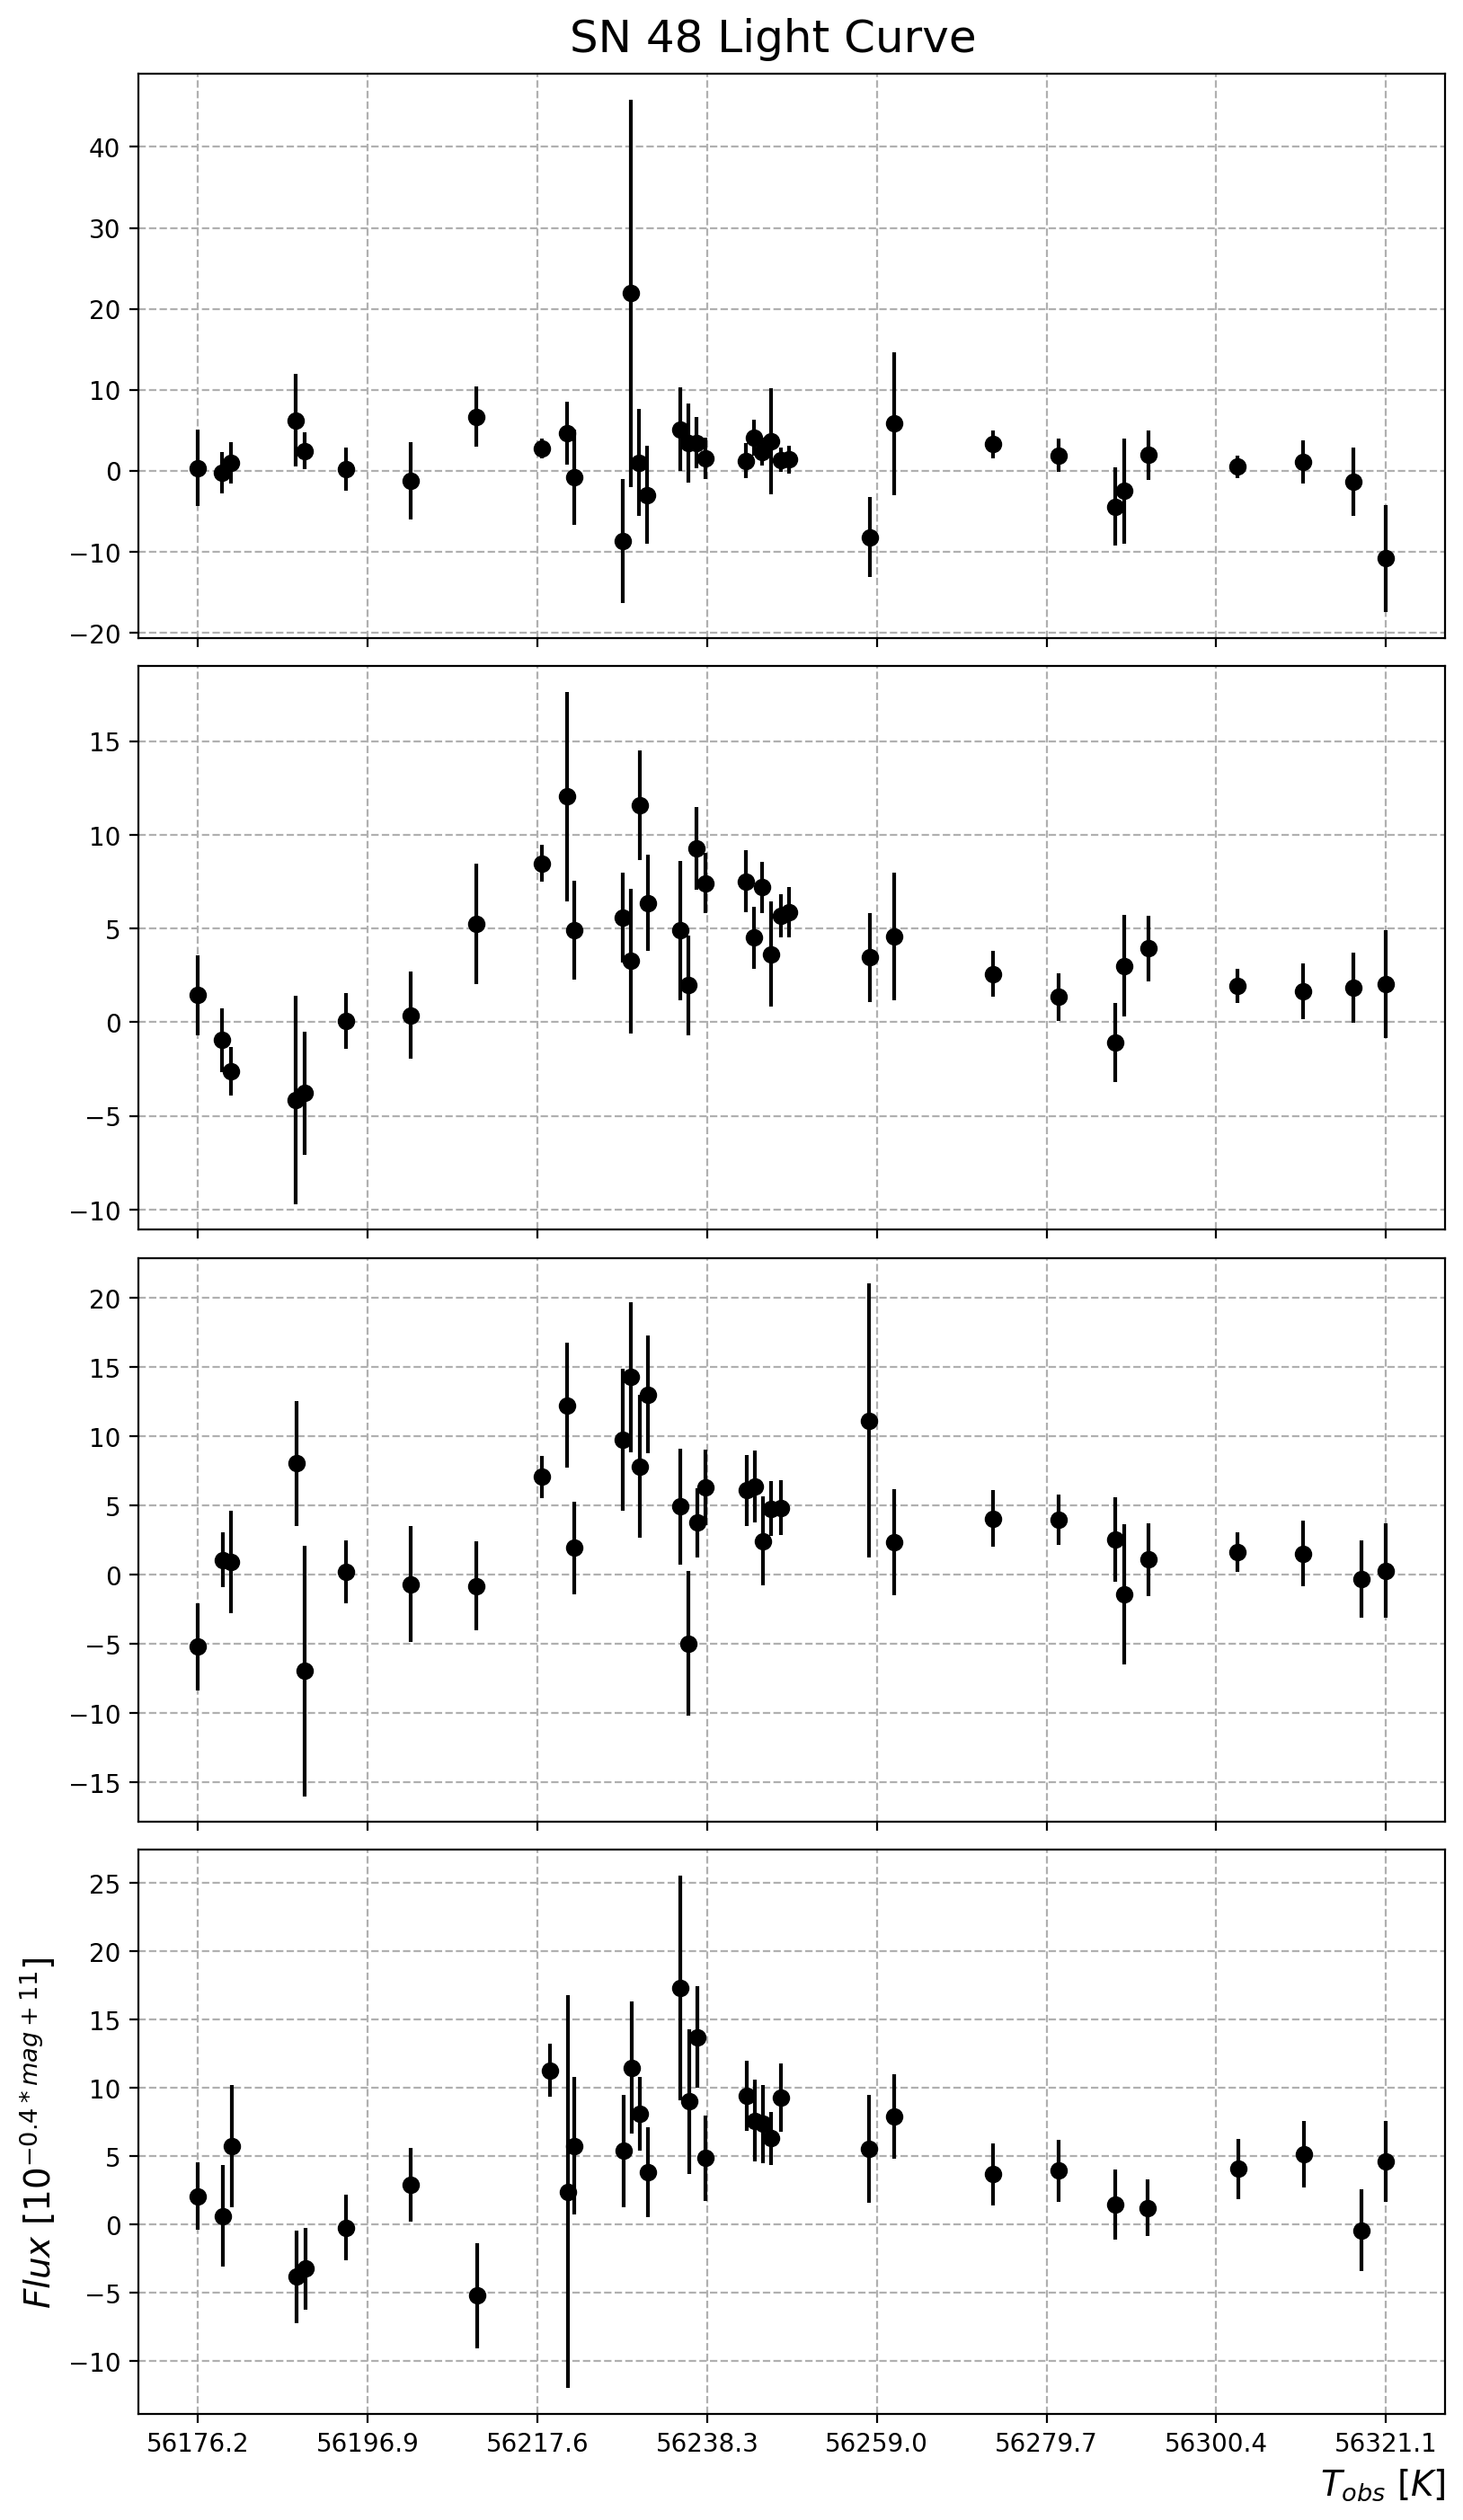

In [5]:
# Plot the SN48 Light Curve
plot_data(data, 48)